In [1]:
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def get_tsne_features(features):
    print(features.shape)
    features = PCA(n_components=50).fit_transform(features)
    print(features.shape)
    features = TSNE(verbose=1,learning_rate='auto',init='pca').fit_transform(features)
    return features
    
# 定义ResNet18模型
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Sequential(*list(torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True).children())[4:-1])
        )
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [3]:
# 定义数据预处理
from models.resnet import ResNet


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载CIFAR10数据集
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

# 实例化ResNet18模型
net = ResNet(num_classes=10,model_name='resnet18', pretrained=True)

# 将模型放到GPU上
net.cuda()
# 定义优化器和损失函数
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 初始化变量
prev_test_accuracy = 0
num_epochs_no_improvement = 0
max_epochs_no_improvement = 5

epochs_per = 100
# 训练新的fc层
for epoch in range(40):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        net.train()
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if i % epochs_per == epochs_per-1:
        #     print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / epochs_per))
        #     running_loss = 0.
    # test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            net.eval()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    print('epoch: %d, test accuracy: %.3f' % (epoch + 1, test_accuracy))

    if test_accuracy <= prev_test_accuracy:
        num_epochs_no_improvement += 1
    else:
        num_epochs_no_improvement = 0

    # 如果连续max_epochs_no_improvement轮准确率不增加，就停止训练
    if num_epochs_no_improvement >= max_epochs_no_improvement:
        print(f"Accuracy has not improved for {max_epochs_no_improvement} epochs. Training stopped.")
        break

    prev_test_accuracy = test_accuracy


Files already downloaded and verified
Files already downloaded and verified
epoch: 1, test accuracy: 73.700
epoch: 2, test accuracy: 77.430
epoch: 3, test accuracy: 79.660
epoch: 4, test accuracy: 81.050
epoch: 5, test accuracy: 81.030
epoch: 6, test accuracy: 81.150
epoch: 7, test accuracy: 81.200
epoch: 8, test accuracy: 82.080
epoch: 9, test accuracy: 80.400
epoch: 10, test accuracy: 81.100
epoch: 11, test accuracy: 80.570
epoch: 12, test accuracy: 80.370
epoch: 13, test accuracy: 81.050
epoch: 14, test accuracy: 81.460
epoch: 15, test accuracy: 80.760
epoch: 16, test accuracy: 81.690
epoch: 17, test accuracy: 81.770
epoch: 18, test accuracy: 81.020
epoch: 19, test accuracy: 81.740
epoch: 20, test accuracy: 80.080
epoch: 21, test accuracy: 82.490
epoch: 22, test accuracy: 80.970
epoch: 23, test accuracy: 81.270
epoch: 24, test accuracy: 81.890
epoch: 25, test accuracy: 80.900
epoch: 26, test accuracy: 81.500
epoch: 27, test accuracy: 81.040
epoch: 28, test accuracy: 81.350
epoch: 29

(6400, 512)
(6400, 50)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.000s...
[t-SNE] Computed neighbors for 6400 samples in 0.963s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 1.902870


/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.949398
[t-SNE] KL divergence after 1000 iterations: 1.054406


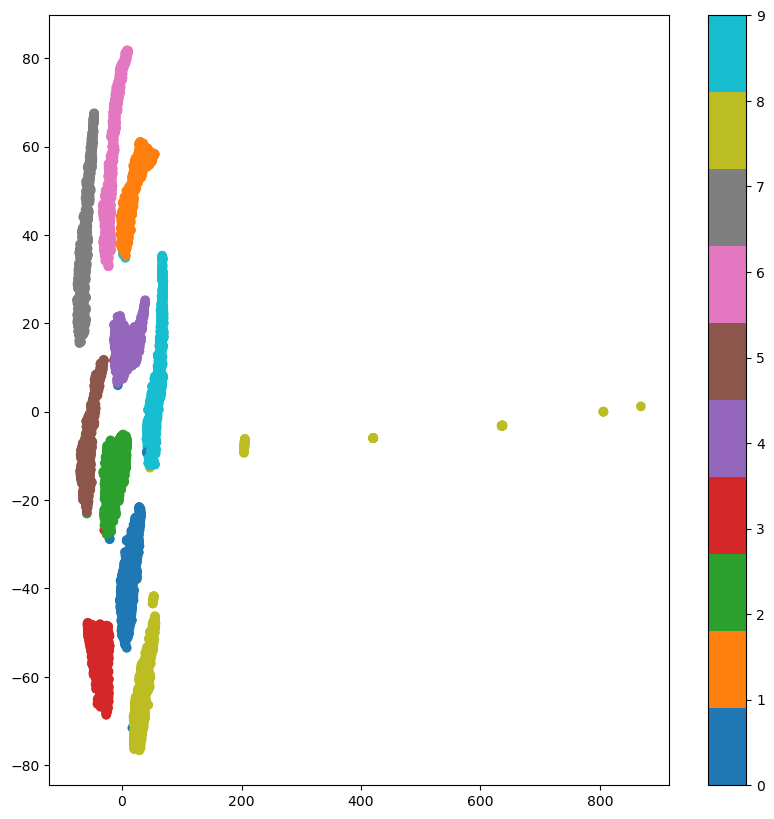

In [7]:
# 提取CIFAR10的ResNet18特征
features = []
labels = []
feature_extractor = nn.Sequential(*list(net.resnet.children())[:-1])
feature_extractor.eval()
for data in trainloader:
    inputs, target = data
    inputs, target = inputs.cuda(), target.cuda()
    # eval
    with torch.no_grad():
        features.append(feature_extractor(inputs).cpu().detach().numpy())
        labels.append(target.cpu().numpy())
    if len(features) == 50:
        break

features = np.concatenate(features, axis=0).squeeze()
labels = np.concatenate(labels, axis=0)

# 使用t-SNE进行可视化
features_tsne = get_tsne_features(features)

plt.figure(figsize=(10, 10))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()